In [2]:
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distr

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 8)

torch.__version__

'0.3.0.post4'

In [3]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [4]:
def cuda_wrapper(tensor, use_cuda=USE_CUDA):
    if use_cuda:
        return tensor.cuda()
    else:
        return tensor

In [5]:
from torchvision import datasets, transforms

kwargs = {}
batch_size = 24
test_batch_size = 24

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data', train=True, download=False,
        transform=transforms.Compose(
            #[transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            [transforms.ToTensor()]
        )
    ), batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data', train=False, 
        transform=transforms.Compose(
            #[transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            [transforms.ToTensor()]
        )
    ), batch_size=test_batch_size, shuffle=True, **kwargs
)


In [6]:
class SigmoidBeliefNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=None, num_blocks=1, hidden_dim=200, nonlinear_blocks=False):
        super(SigmoidBeliefNetwork, self).__init__()
        
        if output_dim is None:
            output_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        layer_input_dim = input_dim
        layer_output_dim = hidden_dim
            
        self.dense_layers = nn.ModuleList()
        self.nonlinearities = nn.ModuleList()
        
        for _ in range(num_blocks):
            self.dense_layers.append(nn.ModuleList())
            self.nonlinearities.append(nn.ModuleList())
            if nonlinear_blocks:
                for _ in range(3):
                    self.dense_layers[-1].append(nn.Linear(layer_input_dim, layer_output_dim))
                    layer_input_dim = layer_output_dim
                    layer_output_dim = hidden_dim
                for _ in range(2):
                    self.nonlinearities[-1].append(nn.Tanh())
                self.nonlinearities[-1].append(nn.Sigmoid())
            else:
                self.dense_layers[-1].append(nn.Linear(layer_input_dim, layer_output_dim))
                layer_input_dim = layer_output_dim
                layer_output_dim = hidden_dim
                self.nonlinearities[-1].append(nn.Sigmoid())
                    
        self.output_layer = nn.Linear(layer_input_dim, output_dim)
        
        self.eps = 1.0e-6
        
    def _soft_forward(self, X, sigmoid_temp, start_block_idx):
        soft_output = X
        for i in range(start_block_idx, self.num_blocks):
            for dense_layer, nonlinearity in zip(self.dense_layers[i], self.nonlinearities[i]):
                soft_output = nonlinearity(dense_layer(soft_output))
            prob = torch.clamp(soft_output, min=self.eps, max=1.-self.eps)
            
            u = autograd.Variable(
                cuda_wrapper(torch.Tensor(prob.size()).uniform_()), requires_grad=False
            )

            z = torch.log(prob * u + self.eps) - torch.log((1 - prob) * (1 - u) + self.eps)
            soft_output = torch.sigmoid(z / sigmoid_temp)
            
        return self.output_layer(soft_output)
            
    def forward(self, X, sigmoid_temp=1.0):
        self.sample_log_probs = []
        final_soft_outputs = []
        final_cond_soft_outputs = []

        hard_output = X
        for i in range(self.num_blocks):
            for dense_layer, nonlinearity in zip(self.dense_layers[i], self.nonlinearities[i]):
                hard_output = nonlinearity(dense_layer(hard_output))
            prob = torch.clamp(hard_output, min=self.eps, max=1.-self.eps)
            
            u = autograd.Variable(
                cuda_wrapper(torch.Tensor(prob.size()).uniform_()), requires_grad=False
            )
            v = autograd.Variable(
                cuda_wrapper(torch.Tensor(prob.size()).uniform_()), requires_grad=False
            )

            z = torch.log(prob * u + self.eps) - torch.log((1 - prob) * (1 - u) + self.eps)
            b = (z > 0)
            v = v * (1 - prob) * (1 - b.float()) + (v * prob + (1 - prob)) * b.float() 
            z_cond = torch.log(prob * v + self.eps) - torch.log((1 - prob) * (1 - v) + self.eps)

            self.sample_log_probs.append(distr.Bernoulli(prob).log_prob(b))
            
            hard_output = b.float()
            soft_output = torch.sigmoid(z / sigmoid_temp)
            cond_soft_output = torch.sigmoid(z_cond / sigmoid_temp)
            
            final_soft_outputs.append(self._soft_forward(soft_output, sigmoid_temp, start_block_idx=i+1))
            final_cond_soft_outputs.append(self._soft_forward(cond_soft_output, sigmoid_temp, start_block_idx=i+1))
        
        final_hard_output = self.output_layer(hard_output)
        return final_hard_output, final_soft_outputs, final_cond_soft_outputs
    

In [7]:
input_dim = train_loader.dataset.train_data.size()
input_dim = input_dim[1] * input_dim[2] // 2
input_dim

392

In [15]:
from time import time

num_steps = 500 * 1000
num_epochs = num_steps * batch_size // train_loader.dataset.train_data.size(0)
#num_epochs = 10
num_blocks = 1

#opt_modes = ['last_epoch_reward_baseline', 'no_baseline', 'reparam_1.0', 'reparam_0.1', 'reparam_10.']
opt_modes = ['rebar_0.1']
train_losses = {}

learning_rate = 0.0001
eta_start = 1.0

logsigmoid = nn.LogSigmoid()

for opt_mode in opt_modes:
    print()
    print(opt_mode)
    train_losses[opt_mode] = []
    model = cuda_wrapper(SigmoidBeliefNetwork(input_dim, num_blocks=num_blocks, hidden_dim=200, nonlinear_blocks=True))
    if num_blocks > 0:
        num_layers = len(model.dense_layers[0])
    else:
        num_layers = 0
        
    eta = autograd.Variable(
        cuda_wrapper(torch.Tensor(num_blocks, num_layers, 2).fill_(eta_start)), requires_grad=True
    )
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99999))
    
    for epoch in range(num_epochs):
        start_time = time()
        print('Epoch {} of {}'.format(epoch+1, num_epochs))
        
        torch.manual_seed(42)
        
        if opt_mode.startswith('reparam'):
            sigmoid_temp = float(opt_mode.split('_')[1])
        elif opt_mode.startswith('rebar'):
            sigmoid_temp = autograd.Variable(
                cuda_wrapper(torch.Tensor([float(opt_mode.split('_')[1])])), requires_grad=True
            )
            optimizer_variance = optim.Adam([eta, sigmoid_temp], betas=(0.9, 0.99999))
        else:
            sigmoid_temp = 1.0
        
        loader = train_loader
        num_samples = train_loader.dataset.train_data.size(0)
        
        cum_losses = 0
        for batch_idx, (data, target) in enumerate(loader):
            top, bottom = torch.chunk(
                (data.view(data.size(0), -1) > 0.5).float(), 2, dim=1
            )
            top, bottom = autograd.Variable(cuda_wrapper(top), requires_grad=False), \
                          autograd.Variable(cuda_wrapper(bottom), requires_grad=False)
            hard_bottom_logit, soft_bottom_logits, soft_cond_bottom_logits = model(top, sigmoid_temp)

            hard_samplewise_loss = -torch.sum(
                logsigmoid(hard_bottom_logit) * bottom + logsigmoid(-hard_bottom_logit) * (1 - bottom), dim=1
            )
            hard_loss = torch.sum(hard_samplewise_loss)

            soft_samplewise_losses = []
            soft_cond_samplewise_losses = []
            soft_losses = []
            soft_cond_losses = []
            for i in range(num_blocks):
                soft_samplewise_losses.append(
                    -torch.sum(
                        logsigmoid(soft_bottom_logits[i]) * bottom +\
                        logsigmoid(-soft_bottom_logits[i]) * (1 - bottom), dim=1
                    )
                )
                soft_losses.append(torch.sum(soft_samplewise_losses[-1]))
                
                soft_cond_samplewise_losses.append(
                    -torch.sum
                    (
                        logsigmoid(soft_cond_bottom_logits[i]) * bottom +\
                        logsigmoid(-soft_cond_bottom_logits[i]) * (1 - bottom), dim=1
                    )
                )
                soft_cond_losses.append(torch.sum(soft_cond_samplewise_losses[-1]))
            
            cum_losses += hard_loss.data.mean()

            optimizer.zero_grad()
            
            if opt_mode.startswith('reparam'):
                soft_losses[0].backward()
                optimizer.step()
        
            elif opt_mode in ['no_baseline', 'last_epoch_reward_baseline']:
                cost = torch.stack([hard_samplewise_loss.detach()] * model.hidden_dim, dim=1)
                if opt_mode == 'no_baseline':
                    baseline = 0
                elif opt_mode == 'last_epoch_reward_baseline':
                    baseline = autograd.Variable(train_losses[opt_mode][-1], requires_grad=False) if epoch > 0 else 0
                for sample_log_prob in model.sample_log_probs:
                    hard_loss += torch.sum(sample_log_prob * (cost - baseline))
                hard_loss.backward()
                optimizer.step()
        
            elif opt_mode.startswith('rebar'):
                loss_eta_linear_coef_grads = []
                for i in range(num_blocks):
                    cost = torch.stack(
                        [-soft_cond_samplewise_losses[i].detach()] * model.hidden_dim, dim=1
                    )
                    loss_eta_linear_coef = soft_losses[i] - soft_cond_losses[i]
                    loss_eta_linear_coef += torch.sum(model.sample_log_probs[i] * cost)
                    loss_eta_linear_coef_grads.append(
                        autograd.grad(
                            loss_eta_linear_coef,
                            [param for dense_layer in model.dense_layers[i] for param in dense_layer.parameters()],
                            create_graph=True, retain_graph=True
                        )
                    )
                            
                cost_additional = torch.stack(
                    [hard_samplewise_loss.detach()] * model.hidden_dim, dim=1
                )
                loss_additional = 0
                for sample_log_prob in model.sample_log_probs:
                    loss_additional += torch.sum(sample_log_prob * cost_additional)
                loss_additional_grads = autograd.grad(
                    loss_additional,
                    [
                        param
                        for i in range(num_blocks)
                        for dense_layer in model.dense_layers[i] 
                        for param in dense_layer.parameters()
                    ],
                    create_graph=True, retain_graph=True
                )
                
                hard_loss.backward(retain_graph=True)

                loss_grads = []
                for i in range(num_blocks):
                    loss_grads.append([])
                    for j, dense_layer in enumerate(model.dense_layers[i]):
                        loss_grads[-1].append([])
                        for k, param in enumerate(dense_layer.parameters()):
                            loss_grads[-1][-1].append(
                                eta[i, j, k] * loss_eta_linear_coef_grads[i][j * 2 + k] +\
                                loss_additional_grads[(i * num_layers + j) * 2 + k]
                            )
                            param.grad = loss_grads[-1][-1][-1]

                optimizer.step()
                optimizer.zero_grad()
                
                variance = 0
                for i in range(num_blocks):
                    for j, dense_layer in enumerate(model.dense_layers[i]):
                        for k, param in enumerate(dense_layer.parameters()):
                            variance += torch.sum(loss_grads[i][j][k] ** 2)
                
                optimizer_variance.zero_grad()
                variance.backward()
                optimizer_variance.step()
                
        mean_loss = cum_losses / num_samples
        print("loss: {:.2f}".format(mean_loss))
        train_losses[opt_mode].append(mean_loss)
        
        for i in range(num_blocks):
            print('block {}:'.format(i + 1))
            for j in range(num_layers):
                print('layer {}:'.format(j + 1))
                print('eta_w: {:.4f}, eta_b: {:.4f}'.format(eta.data[i, j, 0], eta.data[i, j, 1]))
        if opt_mode.startswith('rebar'):
            print('sigmoid_temp: {:.4f}'.format(sigmoid_temp.data[0]))
        
        print('elapsed time: {:.1f}s'.format(time() - start_time))
        print()


rebar_0.1
Epoch 1 of 200
loss: 115.71
block 1:
layer 1:
eta_w: 1.0002, eta_b: 0.9999
layer 2:
eta_w: 1.0004, eta_b: 1.0000
layer 3:
eta_w: 1.0003, eta_b: 1.0003
sigmoid_temp: 0.3837
elapsed time: 44.0s

Epoch 2 of 200
loss: 109.08
block 1:
layer 1:
eta_w: 1.0012, eta_b: 1.0006
layer 2:
eta_w: 1.0006, eta_b: 1.0007
layer 3:
eta_w: 1.0002, eta_b: 1.0002
sigmoid_temp: 0.5225
elapsed time: 43.8s

Epoch 3 of 200
loss: 109.02
block 1:
layer 1:
eta_w: 1.0011, eta_b: 1.0011
layer 2:
eta_w: 1.0003, eta_b: 1.0007
layer 3:
eta_w: 1.0001, eta_b: 1.0001
sigmoid_temp: 0.5468
elapsed time: 44.2s

Epoch 4 of 200
loss: 109.01
block 1:
layer 1:
eta_w: 1.0015, eta_b: 1.0022
layer 2:
eta_w: 1.0006, eta_b: 1.0009
layer 3:
eta_w: 1.0000, eta_b: 1.0000
sigmoid_temp: 0.5280
elapsed time: 44.2s

Epoch 5 of 200
loss: 109.00
block 1:
layer 1:
eta_w: 1.0016, eta_b: 1.0012
layer 2:
eta_w: 1.0009, eta_b: 1.0009
layer 3:
eta_w: 0.9999, eta_b: 0.9999
sigmoid_temp: 0.5044
elapsed time: 43.5s

Epoch 6 of 200
loss: 108

loss: 82.63
block 1:
layer 1:
eta_w: 1.0127, eta_b: 1.0133
layer 2:
eta_w: 1.0085, eta_b: 1.0083
layer 3:
eta_w: 1.0020, eta_b: 1.0017
sigmoid_temp: 0.6222
elapsed time: 44.4s

Epoch 45 of 200
loss: 81.44
block 1:
layer 1:
eta_w: 1.0129, eta_b: 1.0130
layer 2:
eta_w: 1.0103, eta_b: 1.0103
layer 3:
eta_w: 1.0041, eta_b: 1.0040
sigmoid_temp: 0.6165
elapsed time: 44.4s

Epoch 46 of 200
loss: 80.18
block 1:
layer 1:
eta_w: 1.0114, eta_b: 1.0101
layer 2:
eta_w: 1.0093, eta_b: 1.0090
layer 3:
eta_w: 1.0040, eta_b: 1.0039
sigmoid_temp: 0.6726
elapsed time: 45.3s

Epoch 47 of 200
loss: 78.95
block 1:
layer 1:
eta_w: 1.0096, eta_b: 1.0083
layer 2:
eta_w: 1.0098, eta_b: 1.0092
layer 3:
eta_w: 1.0039, eta_b: 1.0038
sigmoid_temp: 0.6108
elapsed time: 45.3s

Epoch 48 of 200
loss: 77.78
block 1:
layer 1:
eta_w: 1.0102, eta_b: 1.0092
layer 2:
eta_w: 1.0098, eta_b: 1.0096
layer 3:
eta_w: 1.0048, eta_b: 1.0046
sigmoid_temp: 0.7551
elapsed time: 44.3s

Epoch 49 of 200
loss: 76.71
block 1:
layer 1:
eta_w

loss: 66.01
block 1:
layer 1:
eta_w: 1.0072, eta_b: 1.0060
layer 2:
eta_w: 1.0062, eta_b: 1.0063
layer 3:
eta_w: 1.0047, eta_b: 1.0045
sigmoid_temp: 0.7651
elapsed time: 44.2s

Epoch 88 of 200
loss: 65.90
block 1:
layer 1:
eta_w: 1.0084, eta_b: 1.0076
layer 2:
eta_w: 1.0069, eta_b: 1.0067
layer 3:
eta_w: 1.0054, eta_b: 1.0055
sigmoid_temp: 0.7813
elapsed time: 43.8s

Epoch 89 of 200
loss: 65.80
block 1:
layer 1:
eta_w: 1.0079, eta_b: 1.0071
layer 2:
eta_w: 1.0074, eta_b: 1.0074
layer 3:
eta_w: 1.0064, eta_b: 1.0060
sigmoid_temp: 0.7531
elapsed time: 44.3s

Epoch 90 of 200
loss: 65.70
block 1:
layer 1:
eta_w: 1.0064, eta_b: 1.0062
layer 2:
eta_w: 1.0060, eta_b: 1.0065
layer 3:
eta_w: 1.0049, eta_b: 1.0046
sigmoid_temp: 0.7741
elapsed time: 44.3s

Epoch 91 of 200
loss: 65.61
block 1:
layer 1:
eta_w: 1.0078, eta_b: 1.0072
layer 2:
eta_w: 1.0063, eta_b: 1.0063
layer 3:
eta_w: 1.0062, eta_b: 1.0057
sigmoid_temp: 0.7521
elapsed time: 44.6s

Epoch 92 of 200
loss: 65.51
block 1:
layer 1:
eta_w

loss: 62.93
block 1:
layer 1:
eta_w: 1.0069, eta_b: 1.0071
layer 2:
eta_w: 1.0068, eta_b: 1.0070
layer 3:
eta_w: 1.0051, eta_b: 1.0045
sigmoid_temp: 0.7366
elapsed time: 46.0s

Epoch 131 of 200
loss: 62.87
block 1:
layer 1:
eta_w: 1.0063, eta_b: 1.0080
layer 2:
eta_w: 1.0063, eta_b: 1.0071
layer 3:
eta_w: 1.0037, eta_b: 1.0031
sigmoid_temp: 0.6814
elapsed time: 45.5s

Epoch 132 of 200
loss: 62.82
block 1:
layer 1:
eta_w: 1.0075, eta_b: 1.0092
layer 2:
eta_w: 1.0065, eta_b: 1.0073
layer 3:
eta_w: 1.0036, eta_b: 1.0032
sigmoid_temp: 0.7661
elapsed time: 46.2s

Epoch 133 of 200
loss: 62.77
block 1:
layer 1:
eta_w: 1.0060, eta_b: 1.0068
layer 2:
eta_w: 1.0063, eta_b: 1.0069
layer 3:
eta_w: 1.0044, eta_b: 1.0038
sigmoid_temp: 0.7440
elapsed time: 45.7s

Epoch 134 of 200
loss: 62.72
block 1:
layer 1:
eta_w: 1.0066, eta_b: 1.0088
layer 2:
eta_w: 1.0067, eta_b: 1.0076
layer 3:
eta_w: 1.0037, eta_b: 1.0033
sigmoid_temp: 0.7028
elapsed time: 45.9s

Epoch 135 of 200
loss: 62.66
block 1:
layer 1:


loss: 61.22
block 1:
layer 1:
eta_w: 1.0018, eta_b: 1.0016
layer 2:
eta_w: 1.0029, eta_b: 1.0027
layer 3:
eta_w: 1.0025, eta_b: 1.0026
sigmoid_temp: 0.7137
elapsed time: 45.9s

Epoch 174 of 200
loss: 61.18
block 1:
layer 1:
eta_w: 1.0038, eta_b: 1.0042
layer 2:
eta_w: 1.0039, eta_b: 1.0039
layer 3:
eta_w: 1.0026, eta_b: 1.0026
sigmoid_temp: 0.7605
elapsed time: 45.6s

Epoch 175 of 200
loss: 61.15
block 1:
layer 1:
eta_w: 1.0052, eta_b: 1.0045
layer 2:
eta_w: 1.0051, eta_b: 1.0052
layer 3:
eta_w: 1.0027, eta_b: 1.0026
sigmoid_temp: 0.7623
elapsed time: 45.6s

Epoch 176 of 200
loss: 61.12
block 1:
layer 1:
eta_w: 1.0070, eta_b: 1.0078
layer 2:
eta_w: 1.0061, eta_b: 1.0062
layer 3:
eta_w: 1.0050, eta_b: 1.0049
sigmoid_temp: 0.8116
elapsed time: 44.9s

Epoch 177 of 200
loss: 61.10
block 1:
layer 1:
eta_w: 1.0020, eta_b: 1.0023
layer 2:
eta_w: 1.0019, eta_b: 1.0018
layer 3:
eta_w: 1.0004, eta_b: 1.0005
sigmoid_temp: 0.7068
elapsed time: 44.9s

Epoch 178 of 200
loss: 61.05
block 1:
layer 1:


## 1 layer non-linear model:

##### 200 epochs corresponds to 500 thousands steps

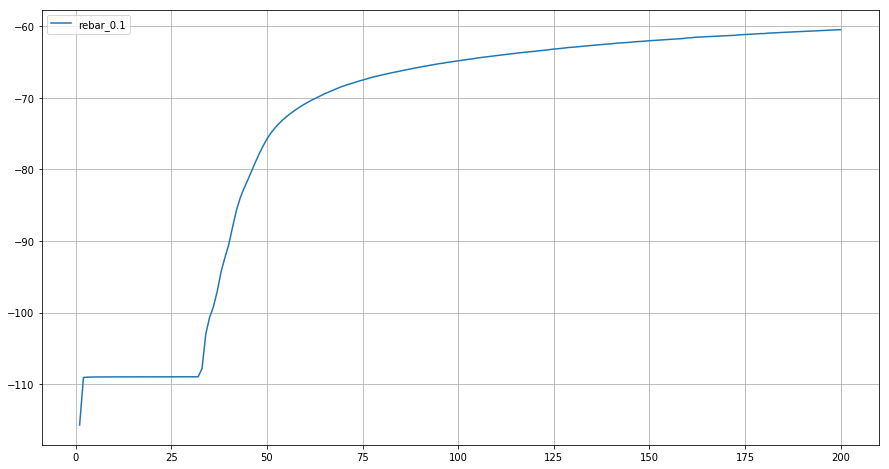

In [16]:
for opt_mode in opt_modes:
    plt.plot(range(1, num_epochs+1), -np.array(train_losses[opt_mode]))
plt.grid(True)
plt.legend(opt_modes)
#plt.plot(test_losses, 'k--')

In [17]:
print('Final performance:')
for opt_mode in opt_modes:
    print('{}: {:.2f}'.format(opt_mode, -train_losses[opt_mode][-1]))

Final performance:
rebar_0.1: -60.48
